# Mapping in Python with `geopandas`

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps
import palettable as pltt
from seaborn import palplot

/home/danie/miniconda3/envs/gds/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In this lab, we will learn how to load, manipulate and visualize spatial data. In some senses, spatial data have become so pervasive that nowadays, they are usually included simply as "one more column" in a table. However, *spatial is special* sometimes and there are few aspects in which geographic data differ from standard numerical tables. In this session, we will extend the skills developed in the previous one about non-spatial data, and combine them. In the process, we will discover that, although with some particularities, dealing with spatial data in Python largely resembles dealing with non-spatial data. For example, in this lab you will learn to make slick maps like this one with just a few commands:

![](figs/lab03_liverpool_lsoas_wa.png)


To learn these concepts, we will be playing with the geography of Liverpool. In particular we will use Census geographies (Available as part of the Census Data pack used before, see [link](https://data.cdrc.ac.uk/dataset/cdrc-2011-census-data-packs-for-local-authority-district-liverpool-e08000012)) and Ordnance Survey geospatial data, available to download also from the CDRC data store ([link](https://data.cdrc.ac.uk/dataset/cdrc-2015-os-geodata-pack-liverpool-e08000012)). To make the rest of the notebook easier to follow, let us set the paths to the main two folders here. We will call the path to the Liverpool Census pack `lcp_dir`, and that to the OS geodata `los_dir`:

In [2]:
# This might have to look different in your computer
lcp_dir = '../../../gds18_data/Liverpool/'
los_dir = '../../../gds18_data/E08000012_OS/'

**IMPORTANT**: the paths above might have look different in your computer. See [this introductory notebook](begin.html) for more details about how to set your paths.

## Loading up spatial data

The most direct way to get from a file to a quick visualization of the data is by loading it as a `GeoDataFrame` and calling the `plot` command. The main library employed for all of this is `geopandas` which is a geospatial extension of the `pandas` library, already introduced before. `geopandas` supports exactly the same functionality that `pandas` does (in fact since it is built on top of it, so most of the underlying machinery is pure `pandas`), plus a wide range of spatial counterparts that make manipulation and general "munging" of spatial data very similar to non-spatial tables.

In two lines of code, we will obtain a graphical representation of the spatial data contained in a file that can be in many formats; actually, since it uses the same drivers under the hood, you can load pretty much the same kind of vector files that QGIS permits. Let us start by plotting single layers in a crude but quick form, and we will build style and sophistication into our plots later on.

* Polygons

Let us begin with the most common type of spatial data in the social science: polygons. For example, we can load the geography of LSOAs in Liverpool with the following lines of code:

In [3]:
lsoas_link = lcp_dir + 'shapefiles/Liverpool_lsoa11.shp'
lsoas = gpd.read_file(lsoas_link)

Now `lsoas` is a `GeoDataFrame`. Very similar to a traditional, non-spatial `DataFrame`, but with an additional column called `geometry`:

In [4]:
lsoas.head()

,LSOA11CD,geometry
0,E01006512,"POLYGON ((336103.358 389628.58, 336103.416 389..."
1,E01006513,"POLYGON ((335173.781 389691.538, 335169.798 38..."
2,E01006514,"POLYGON ((335495.676 389697.267, 335495.444 38..."
3,E01006515,"POLYGON ((334953.001 389029, 334951 389035, 33..."
4,E01006518,"POLYGON ((335354.015 388601.947, 335354 388602..."


This allows us to quickly produce a plot by executing the following line:

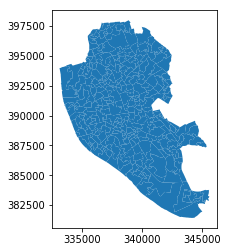

In [5]:
lsoas.plot()

This might not be the most aesthetically pleasant visual representation of the LSOAs geography, but it is hard to argue it is not quick to produce. We will work on styling and customizing spatial plots later on.

**Pro-tip**: if you call a single row of the `geometry` column, it'll return a small plot ith the shape:

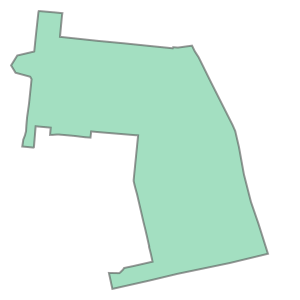

In [6]:
lsoas.loc[0, 'geometry']

* Lines

Displaying lines is as straight-forward as polygons. To load railway tunnels in Liverpool and name the rows after the `id` column (or to "index" them):

In [7]:
# Read file with tunnel
rwy_tun = gpd.read_file(los_dir + 'RailwayTunnel.shp')
# Index it on column `id`
rwy_tun = rwy_tun.set_index('id')
# Print summary info
rwy_tun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 44 entries, 0ACD196C321E4F8DE050A00A568A6F6F to 0ACD196C313D4F8DE050A00A568A6F6F
Data columns (total 2 columns):
featcode    44 non-null float64
geometry    44 non-null object
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


Note how, similarly to the polygon case, if we pick the `"geometry"` column of a table with lines, a single row will display the geometry as well:

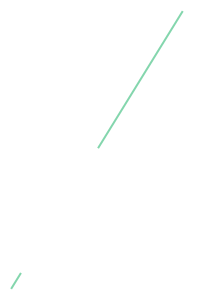

In [8]:
rwy_tun.loc['0ACD196C313D4F8DE050A00A568A6F6F', 'geometry']

Note how we have also indexed the table on the `id` column.

A quick plot is similarly generated by (mind that because there are over 18,000 segments, this may take a little bit):

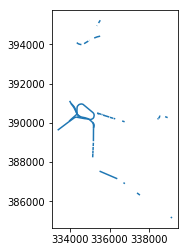

In [9]:
rwy_tun.plot()

Again, this is not the prettiest way to display the roads maybe, and you might want to change a few parameters such as colors, etc. All of this is possible, as we will see below, but this gives us a quick check of what lines look like.

---

**[Optional exercise]**

Obtain the graphical representation of the line with `id` = `0ACD196C32214F8DE050A00A568A6F6F`.

<!--
rwy_tun.loc['0ACD196C313D4F8DE050A00A568A6F6F', 'geometry']
-->

---

* Points

Finally, points follow a similar structure. If we want to represent named places in Liverpool:

In [10]:
namp = gpd.read_file(los_dir + 'NamedPlace.shp')
namp.head()

,id,distname,htmlname,classifica,fontheight,orientatio,featcode,geometry
0,0EE7A103C03A8FBFE050A00A568A2502,Sugar Brook,Sugar Brook,Hydrography,Small,25.0,15804.0,POINT (339605 396261)
1,0EE7A104A4B68FBFE050A00A568A2502,Sandfield Park,Sandfield Park,Landcover,Small,0.0,15805.0,POINT (339758 392357)
2,0EE7A1041DB18FBFE050A00A568A2502,Sandfield Park,Sandfield Park,Populated Place,Medium,0.0,15801.0,POINT (339768 392217)
3,0EE7A1041DE48FBFE050A00A568A2502,Gillmoss,Gillmoss,Populated Place,Medium,0.0,15801.0,POINT (340269 396567)
4,0EE7A1041DE58FBFE050A00A568A2502,Croxteth,Croxteth,Populated Place,Medium,0.0,15801.0,POINT (340296 395304)


And the plot is produced by running:

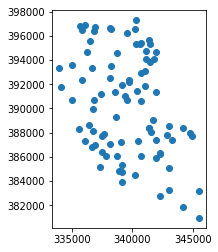

In [11]:
namp.plot()

## Styling plots

It is possible to tweak several aspects of a plot to customize if to particular needs. In this section, we will explore some of the basic elements that will allow us to obtain more compelling maps.

**NOTE**: some of these variations are very straightforward while others are more intricate and require tinkering with the internal parts of a plot. They are not necessarily organized by increasing level of complexity.

* Changing transparency

The intensity of color of a polygon can be easily changed through the `alpha` attribute in plot. This is specified as a value betwee zero and one, where the former is entirely transparent while the latter is the fully opaque (maximum intensity):

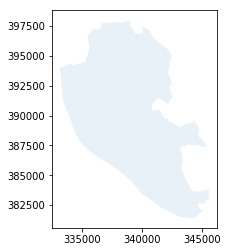

In [12]:
lsoas.plot(alpha=0.1)

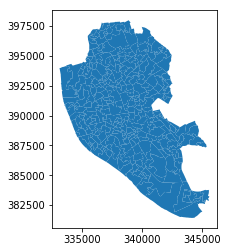

In [13]:
lsoas.plot(alpha=1)

* Removing axes

Although in some cases, the axes can be useful to obtain context, most of the times maps look and feel better without them. Removing the axes involves wrapping the plot into a figure, which takes a few more lines of aparently useless code but that, in time, it will allow you to tweak the map further and to create much more flexible designs:

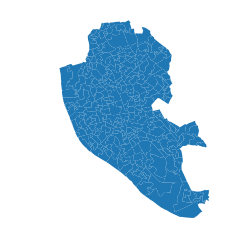

In [14]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Plot layer of polygons on the axis
lsoas.plot(ax=ax)
# Remove axis frames
ax.set_axis_off()
# Display
plt.show()

Let us stop for a second a study each of the previous lines:

1. We have first created a figure named `f` with one axis named `ax` by using the command `plt.subplots` (part of the library `matplotlib`, which we have imported at the top of the notebook). Note how the method is returning two elements and we can assign each of them to objects with different name (`f` and `ax`) by simply listing them at the front of the line, separated by commas.
1. Second, we plot the geographies as before, but this time we tell the function that we want it to draw the polygons on the axis we are passing, `ax`. This method returns the axis with the geographies in them, so we make sure to store it on an object with the same name, `ax`.
1. On the third line, we effectively remove the box with coordinates.
1. Finally, we draw the entire plot by calling `plt.show()`.

* Adding a title

Adding a title is an extra line, if we are creating the plot within a figure, as we just did. To include text on top of the figure:

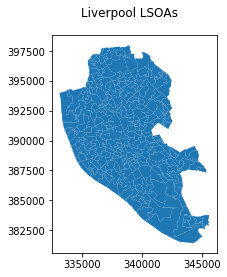

In [15]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer of polygons on the axis
lsoas.plot(ax=ax)
# Add figure title
f.suptitle('Liverpool LSOAs')
# Display
plt.show()

* Changing the size of the map

The size of the plot is changed equally easily in this context. The only difference is that it is specified when we create the figure with the argument `figsize`. The first number represents the width, the X axis, and the second corresponds with the height, the Y axis.

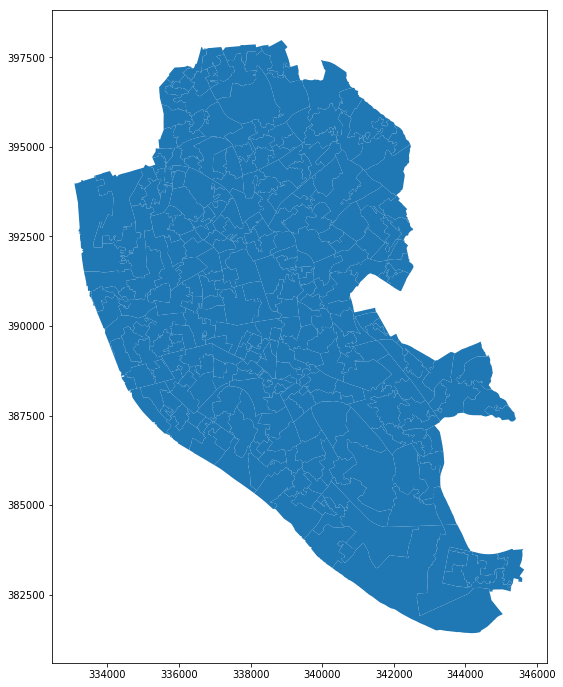

In [16]:
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
lsoas.plot(ax=ax)
# Display
plt.show()

* Scaling plots

You will notice that the ability to change the size of the figure is very powerful as it makes possible to obtain many different sizes and shapes for plots. However, this also may introduce some distortions in the way the shapes are represented. For example, a very wide figure can make the viewer think that polygons are in reality more "stretched out" than they are in reality:

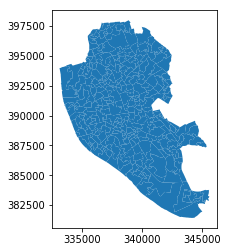

In [17]:
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 4))
# Add layer of polygons on the axis
ax = lsoas.plot(ax=ax)
# Display
plt.show()

Although in some contexts this may be desirable (or at least, accepted), in many it will not. From a cartographic point of view, maps need to be as good representatios of reality as they can. We can ensure the scaling ratio between both axes remains fixed, whichever the shape of the figure. To do this, we only need to add a single extra line of code: `plt.axis("equal")`.

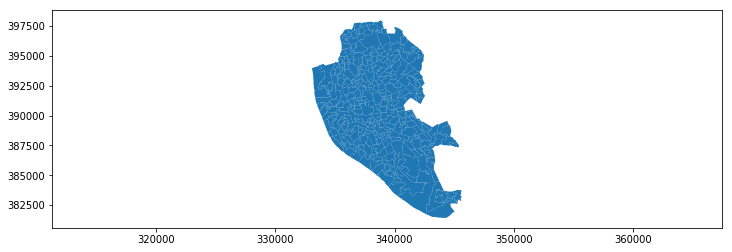

In [18]:
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 4))
# Add layer of polygons on the axis
lsoas.plot(ax=ax)
# Force axis to be on the same unit
plt.axis('equal')
# Display
plt.show()

* Modifying borders

Border lines sometimes can distort or impede proper interpretation of a map. In those cases, it is useful to know how they can be modified. Although not too complicated, the way to access borders in `geopandas` is not as straightforward as it is the case for other aspects of the map, such as size or frame. Let us first see the code to make the *lines thinner* and *grey*, and then we will work our way through the different steps:

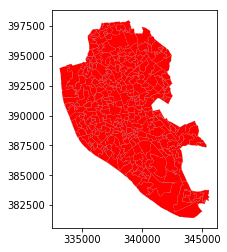

In [19]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer of polygons on the axis, set fill color (`facecolor`) and boundary
# color (`edgecolor`)
lsoas.plot(linewidth=0.1, facecolor='red', edgecolor='grey', ax=ax)
# Display
plt.show()

Note how the lines are much thinner and discreet. In addition, all the polygons are colored in the same (default) color, light red.

Let us examine line by line what we are doing in the code snippet:

* We begin by creating the figure (`f`) object and one axis inside it (`ax`) where we will plot the map.
* Then, we call `plot` as usual, but pass in two new arguments: `facecolor`, to control the color each polygon is filled with, and `edgecolor`, to control the color of the boundary.
* Draw the map using `plt.show()`.

This approach works very similarly with other geometries, such as lines. For example, if we wanted to plot the railway tunnels in red, we would simply:

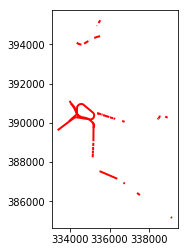

In [20]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer with lines, set them red and with different line width
# and append it to the axis `ax`
rwy_tun.plot(linewidth=2, color='red', ax=ax)
# Display
plt.show()

Important, note that in the case of lines the parameter to control the color is simply `color`. This is because lines do not have an area, so there is no need to distinguish between the main area (`facecolor`) and the border lines (`edgecolor`).

* Transforming CRS

The coordindate reference system (CRS) is the way geographers and cartographers have to represent a three-dimentional object, such as the round earth, on a two-dimensional plane, such as a piece of paper or a computer screen. If the source data contain information on the CRS of the data, we can modify this in a `GeoDataFrame`. First let us check if we have the information stored properly:

In [21]:
lsoas.crs

{'proj': 'tmerc',
 'lat_0': 49,
 'lon_0': -2,
 'k': 0.9996012717,
 'x_0': 400000,
 'y_0': -100000,
 'datum': 'OSGB36',
 'units': 'm',
 'no_defs': True}

As we can see, there is information stored about the reference system: it is using the datum "OSGB36", which is a projection in meters (`m` in units). There are also other less decipherable parameters but we do not need to worry about them right now.

If we want to modify this and "reproject" the polygons into a different CRS, the quickest way is to find the [EPSG](https://en.wikipedia.org/wiki/International_Association_of_Oil_%26_Gas_Producers#European_Petroleum_Survey_Group) code online ([epsg.io](http://epsg.io/) is a good one, although there are others too). For example, if we wanted to transform the dataset into lat/lon coordinates, we would use its EPSG code, 4326:

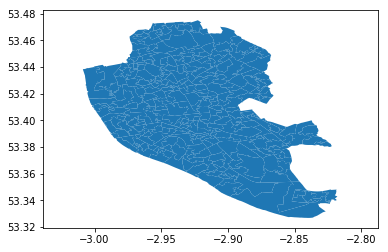

In [22]:
# Reproject (`to_crs`) and plot (`plot`) polygons
lsoas.to_crs(epsg=4326).plot()
# Set equal axis
lims = plt.axis('equal')

Because the area we are visualizing is not very large, the shape of the polygons is roughly the same. However, note how the *scale* in which they are plotted differs: while before we had coordinate points ranging 332,000 to 398,000, now these are expressed in degrees, and range from -3.05 to -2,80 on the longitude, and between 53.32 and 53.48 on the latitude.

---

**[Optional exercise]**

Make a map of the LSOAs that features the following characteristics:

* Includes a title
* Does not include axes frame
* It is proportioned and has a figure size of 10 by 11.
* Polygons are all in the color "#525252" and fully opaque.
* Lines have a width of 0.3 and are of color "#B9EBE3"


<!---
f, ax = plt.subplots(1, figsize=(10, 11))
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='#525252', linewidth=0.3, edgecolor='#B9EBE3')
ax.set_axis_off()
f.suptitle("LSOAs in Liverpool")
plt.axis('equal')
plt.savefig('figs/lab03_liverpool_lsoas.png', dpi=75)
plt.show()
-->

---

## Composing multi-layer maps

So far we have considered many aspects of plotting *a single* layer of data. However, in many cases, an effective map will require more than one: for example we might want to display streets on top of the polygons of neighborhoods, and add a few points for specific locations we want to highlight. At the very heart of GIS is the possibility to combine spatial information from different sources by overlaying it on top of each other, and this is fully supported in Python.

Essentially, combining different layers on a single map boils down to adding each of them to the same axis in a sequential way, as if we were literally overlaying one on top of the previous one. For example, let us get the most direct plot, one with the polygons from the LSOAs and the tunnels on top of them:

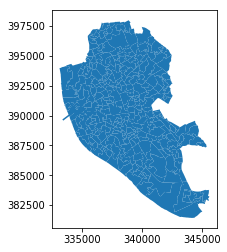

In [23]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygons on to axis `ax`
lsoas.plot(ax=ax)
# Add a layer with lines on top in axis `ax`
rwy_tun.plot(ax=ax)
# Display
plt.show()

Because the default colors are not really designed to mix and match several layers, it is hard to tell them apart. However, we can use all the skills and tricks learned on styling a single layer, to make a multi-layer more sophisticated and, ultimately, useful.

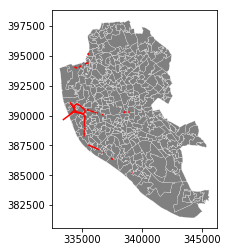

In [24]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygons on to axis `ax`
lsoas.plot(ax=ax, facecolor='grey', edgecolor='white', linewidth=0.2)
# Add a layer with lines on top in axis `ax`
rwy_tun.plot(ax=ax, color='red')
# Display
plt.show()

---

**[Optional exercise]**

Create a similar map to the one above, but replace the railway tunnels by the named places points used at the beginning (and saved into `namp`). Do not try to set the color to green or any other particular one, but you can play with the size of the dot.

<!--
f, ax = plt.subplots(1)
# Plot polygons in light grey
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='grey', alpha=0.25, linewidth=0.1)
# Overlay points
for pt in namp['geometry']:
    gpd.plotting.plot_point(ax, pt, markersize=4)
plt.show()
-->

---

## Using palettes to create aesthetically pleasant maps

The choice of colors can influence the look and, ultimately, the effectiveness of a map. Although in some cases picking colors that simply allow you to distinguish the different elements might suffice, sometimes, you want to convey certain feelings (warmth, safety, etc.). In those cases, using preexisting palettes can be useful.

In this section, we will learn how to use pre-existent palettes to style your maps. We will be using the library [`palettable`](https://jiffyclub.github.io/palettable/), which provides many "canned" palettes. We will also use the handy function `palplot` (from the library `seaborn`) to examine the colors quickly.

For the sake of the example, let us use a palette based on one of Wes Anderson's movies, Darjeeling Limited:

<img src='http://66.media.tumblr.com/2815b755b493555dd4a74fc9f7c84bdb/tumblr_nj7cclt9qb1tvvqeko1_500.jpg'></img>

Here is how you can pull out those colors:

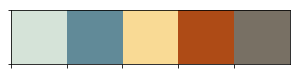

In [25]:
wes = pltt.wesanderson.Darjeeling2_5.hex_colors
palplot(wes)

Now, note how the object `wes` simply contains a list of colors in the hex standard:

In [26]:
wes

['#D5E3D8', '#618A98', '#F9DA95', '#AE4B16', '#787064']

We will use these to style our map. For the sake of the example, let us use the following layers, available from the OS pack:

* `TidalWater`
* `Road`
* `TidalBoundary`
* `FunctionalSite`
* And the LSOA polygons used above.

Let us first read those in:

In [27]:
# NOTE: this might take a little bit depending on the machine
tidW = gpd.read_file(los_dir+'TidalWater.shp')
tidB = gpd.read_file(los_dir+'TidalBoundary.shp')
funS = gpd.read_file(los_dir+'FunctionalSite.shp')
road = gpd.read_file(los_dir+'Road.shp')

Technically speaking, there is nothing new to learn, other than keeping in mind that we need to add the layers in the right order. Let's go for it:

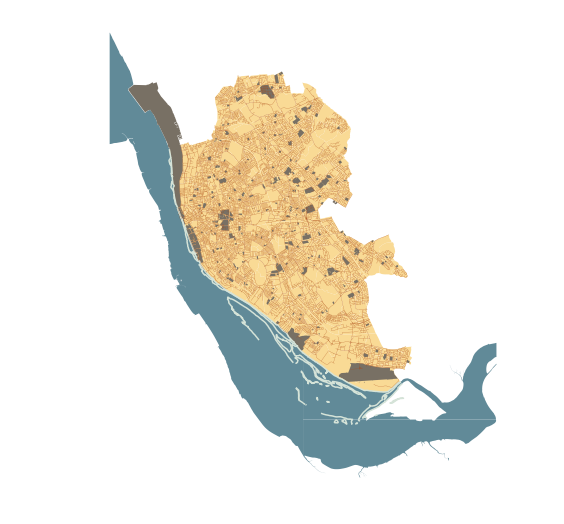

In [28]:
# NOTE: this might take a little bit depending on the machine

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add tidal water (remove boundary lines for the polygons)
tidW.plot(ax=ax, facecolor='#618A98', linewidth=0.)
# Add tidal boundaries
tidB.plot(ax=ax, color='#D5E3D8')
# Add LSOAs
lsoas.plot(ax=ax, facecolor='#F9DA95', edgecolor='#F9DA95', linewidth=0.)
# Add roads
road.plot(ax=ax, color='#AE4B16', linewidth=0.2)
# Add functional sites (remove boundary lines for the polygons)
funS.plot(ax=ax, facecolor='#787064', linewidth=0.)
# Remove axes
ax.set_axis_off()
# Impose same size for units across axes
plt.axis('equal')
# Display
plt.show()

## Saving maps to figures

Once we have produced a map we are content with, we might want to save it to a file so we can include it into a report, article, website, etc. Exporting maps in Python involves replacing `plt.show` by `plt.savefig` at the end of the code block to specify where and how to save it. For example to save the previous map into a `png` file in the same folder where the notebook is hosted:

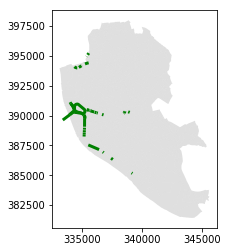

In [29]:
# Set up figure and axes
f, ax = plt.subplots(1)
# Plot polygon layer
lsoas.plot(ax=ax, facecolor='grey', alpha=0.25, linewidth=0.1)
# Plot line layer
rwy_tun.plot(ax=ax, color='green', linewidth=3)
# Save figure to a PNG file
plt.savefig('liverpool_railway_tunels.png')

If you now check on the folder, you'll find a `png` (image) file with the map.

The command `plt.savefig` contains a large number of options and additional parameters to tweak. Given the size of the figure created is not very large, we can increase this with the argument `dpi`, which stands for "dots per inch" and it's a standard measure of resolution in images. For example, for a high definition (HD) quality image, we can use 1080:

**[Note]**: if this takes too long, try with 500 instead, which will still give you a good quality image that renders more easily.

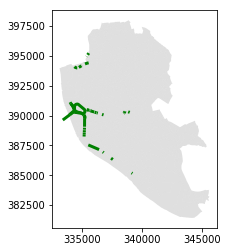

In [30]:
# Set up figure and axes
f, ax = plt.subplots(1)
# Plot polygon layer
lsoas.plot(ax=ax, facecolor='grey', alpha=0.25, linewidth=0.1)
# Plot line layer
rwy_tun.plot(ax=ax, color='green', linewidth=3)
# Save figure to a PNG file
plt.savefig('liverpool_railway_tunels.png', dpi=1080)

## Manipulating spatial tables (`GeoDataFrames`)

Once we have an understanding of how to visually display spatial information contained, let us see how it can be combined with the operations learnt in the previous session about manipulating non-spatial tabular data. Essentially, the key is to realize that a `GeoDataFrame` contains most of its spatial information in a single column named `geometry`, but the rest of it looks and behaves exactly like a non-spatial `DataFrame` (in fact, it is). This concedes them all the flexibility and convenience that we saw in manipulating, slicing, and transforming tabular data, with the bonus that spatial data is carried away in all those steps. In addition, `GeoDataFrames` also incorporate a set of explicitly spatial operations to combine and transform data. In this section, we will consider both.

Let us refresh some of the techniques we learned in the previous session about non-spatial tabular data and see how those can be combined with the mapping of their spatial counter-parts. To do this, we will revisit the population data we explored in the previous section:

In [31]:
import pandas as pd

# Set the path to the location of the Liverpool data from the first practical
# just as you did at the beginning of the previous session
tab_path = 'data/liv_pop.csv'

Remember the data we want need to be extracted and renamed for the variables to have human readable names. Here we will do it all in one shot, but you can go back to the notebook of the previous session to follow the steps in more detail.

In [32]:
# Read file in
lsoa_orig_sub = pd.read_csv(tab_path, index_col=0)
# Create column with totals by area
lsoa_orig_sub['Total'] = lsoa_orig_sub.sum(axis=1)
# Display top of table
lsoa_orig_sub.head()

,Europe,Africa,Middle East and Asia,The Americas and the Caribbean,Antarctica and Oceania,Total
GeographyCode,,,,,,
E01006512,910,106,840,24,0,1880
E01006513,2225,61,595,53,7,2941
E01006514,1786,63,193,61,5,2108
E01006515,974,29,185,18,2,1208
E01006518,1531,69,73,19,4,1696


* Join tabular data

Now we have both tables loaded into the session: on the one hand, the spatial data are contained in `lsoas`, while all the tabular data are in `lsoa_orig_sub`. To be able to work with the two together, we need to *connect* them. In `pandas` language, this is called "join" and the key element in joins are the *indices*, the names assigned to each row of the tables. This is what we determine, for example, when we indicate `index_col` when reading a `csv`. In the case above, the index is set on `GeographyCode`. In the case of the `GeoDataFrame`, there is not any specific index, but an unamed sequence. The spatial table does have however a column called `LSOA11CD` which represents the code for each polygon, and this one actually matches those in `GeographyCode` in the population table.

In [33]:
lsoas.head()

,LSOA11CD,geometry
0,E01006512,"POLYGON ((336103.358 389628.58, 336103.416 389..."
1,E01006513,"POLYGON ((335173.781 389691.538, 335169.798 38..."
2,E01006514,"POLYGON ((335495.676 389697.267, 335495.444 38..."
3,E01006515,"POLYGON ((334953.001 389029, 334951 389035, 33..."
4,E01006518,"POLYGON ((335354.015 388601.947, 335354 388602..."


Having the same column, albeit named differently, in both tables thus allows us to combine, *"join"*, the two into a single one where rows are matched that we will call `geo_pop`:

In [34]:
geo_pop = lsoas.join(lsoa_orig_sub, on='LSOA11CD')
geo_pop.head()

,LSOA11CD,geometry,Europe,Africa,Middle East and Asia,The Americas and the Caribbean,Antarctica and Oceania,Total
0,E01006512,"POLYGON ((336103.358 389628.58, 336103.416 389...",910,106,840,24,0,1880
1,E01006513,"POLYGON ((335173.781 389691.538, 335169.798 38...",2225,61,595,53,7,2941
2,E01006514,"POLYGON ((335495.676 389697.267, 335495.444 38...",1786,63,193,61,5,2108
3,E01006515,"POLYGON ((334953.001 389029, 334951 389035, 33...",974,29,185,18,2,1208
4,E01006518,"POLYGON ((335354.015 388601.947, 335354 388602...",1531,69,73,19,4,1696


Let us quickly run through the logic of joins:

* First, it is an operation in which you are "attaching" some data to a previously existing one. This does not always need to be like this but, for now, we will only consider this case. In particular, in the operation above, we are attaching the population data in `lsoa_orig_sub` to the spatial table `lsoas`.
* Second, note how the main table does not need to be indexed in the shared column for the join to be possible, it only needs to contain it. In this case, the index of `lsoas` is a sequence, but the relevant codes are stored in the column `LSOA11CD`.
* Third, the table that is being attached *does* need to be indexed on the relevant column. This is fine with us because `lsoa_orig_sub` *is* already indexed on the relevant ID codes.
* Finally, note how the join operation contains two arguments: one is obviously the table we want to attach; the second one, preceded by "`on`" relates to the column in the main table that is required to be matched with the index of the table being attached. In this case, the relevant ID codes are in the column `LSOA11CD`, so we specify that.

One final note, earlier versions of `geopandas` appears to have a bug in the code that makes the joined table to loose the CRS. If this is the case, reattaching it is straightforward:

In [35]:
geo_pop.crs = lsoas.crs

### Non-spatial manipulations

Once we have joined spatial and non-spatial data, we can use the techniques learned in manipulating and slicing non-spatial tables to create much richer maps. In particular, let us recall the example we worked through in the previous session in which we were selecting rows based on their population characteristics. In addition to being able to to select them, now we will also be able to visualize them in maps.

For example, let us select again the ten smallest areas of Liverpool (note how we pass a number to `head` to keep that amount of rows):

In [36]:
smallest = geo_pop.sort_values('Total').head(10)

Now we can make a map of Liverpool and overlay on top of them these areas:

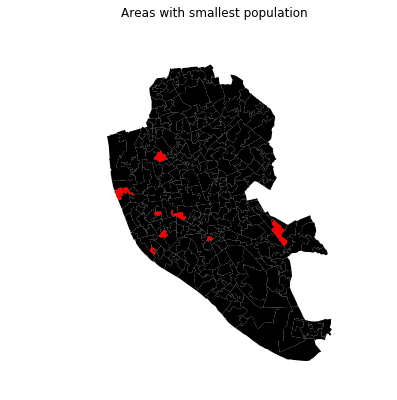

In [37]:
f, ax = plt.subplots(1, figsize=(6, 6))
# Base layer with all the areas for the background
geo_pop.plot(facecolor='black', linewidth=0.025, ax=ax)
# Smallest areas
smallest.plot(alpha=1, facecolor='red', linewidth=0, ax=ax)
ax.set_axis_off()
f.suptitle('Areas with smallest population')
plt.axis('equal')
plt.show()

---

**[Optional exercise]**

Create a map of Liverpool with the two largest areas for each of the different population subgroups in a different color each.

---

### Spatial manipulations

In addition to operations purely based on values of the table, as above, `GeoDataFrame`s come built-in with a whole range of traditional GIS operations. Here we will run through a small subset of them that contains some of the most commonly used ones.

* Centroid calculation

Sometimes it is useful to summarize a polygon into a single point and, for that, a good candidate is its centroid (almost like a spatial analogue of the average). The following command will return a `GeoSeries` (a single column with spatial data) with the centroids of a polygon `GeoDataFrame`:

In [38]:
cents = geo_pop.centroid
cents.head()

0     POINT (336154.2863649924 389733.635773753)
1    POINT (335535.9278617767 390060.8596847057)
2    POINT (335525.0607160075 389484.4020273419)
3    POINT (335117.4359614222 389195.6749620197)
4     POINT (335532.691301766 388692.8415110898)
dtype: object

Note how `cents` is not an entire table but a single column, or a `GeoSeries` object. This means you can plot it directly, just like a table:

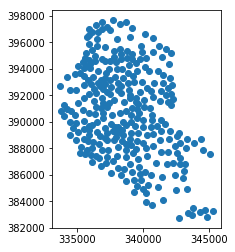

In [39]:
cents.plot()

But you don't need to call a `geometry` column to inspect the spatial objects. In fact, if you do it will return an error because there is not any `geometry` column, the object `cents` itself is the geometry.

---

**[Optional exercise]**

Create a map with the polygons of Liverpool in the background and overlay on top of them their centroids.

<!--
f, ax = plt.subplots(1, figsize=(6, 6))
# Base layer with all the areas for the background
for poly in geo_pop['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='black', linewidth=0.025)
# Smallest areas
cents.plot(axes=ax)
ax.set_axis_off()
f.suptitle('Areas with smallest population')
plt.axis('equal')
plt.show()
-->

---

* Point in polygon (PiP)

Knowing whether a point is inside a polygon is conceptually a straightforward exercise but computationally a tricky task to perform. The way to perform this operation in `GeoPandas` is through the `contains` method, available for each polygon object.

In [40]:
poly = geo_pop['geometry'][0]
pt1 = cents[0]
pt2 = cents[1]

In [41]:
poly.contains(pt1)

True

In [42]:
poly.contains(pt2)

False

Performing point-in-polygon in this way is instructive and useful for pedagogical reasons, but for cases with many points and polygons, it is not particularly efficient. In these situations, it is much more advisable to perform then as a "spatial join". If you are interested in these, see the link provided below to learn more about them.

---

**[Optional exercise]**

This one is fairly advanced, so do not dispair if you cannot solve it. Find in which polygons the named places in `namp` fall into. Return, for each named place, the LSOA code in which it is located.

<!--
pip = []
for id, place in namp.iterrows():
    for pid, poly in geo_pop.iterrows():
        if poly.geometry.contains(place.geometry):
            pip.append((place.htmlname, poly.LSOA11CD))
pip = pd.DataFrame(pip, columns=['NamePlace', 'LSOA'])
-->

---

* Buffers

Buffers are one of the classical GIS operations in which an area is drawn around a particular geometry, given a specific radious. These are very useful, for instance, in combination with point-in-polygon operations to calculate accessibility, catchment areas, etc.

To create a buffer using `geopandas`, simply call the `buffer` method, passing in the radious. Mind that the radious needs to be specified in the same units as the CRS of the geography you are working with. For example, for the named places, we can consider their CRS:

In [43]:
namp.crs

{'init': 'epsg:27700'}

These tells us it uses projection 27700 in the EPSG system. If we [look it up](http://epsg.io/27700), we will find that this corresponds with the Ordnance Survey projection, which is expressed in metres. Hence if we want, for example, a buffer of 500m. around each of these places, we can simply obtain it by:

In [44]:
buf = namp.buffer(500)
buf.head()

0    POLYGON ((340105 396261, 340102.5923633361 396...
1    POLYGON ((340258 392357, 340255.5923633361 392...
2    POLYGON ((340268 392217, 340265.5923633361 392...
3    POLYGON ((340769 396567, 340766.5923633361 396...
4    POLYGON ((340796 395304, 340793.5923633361 395...
dtype: object

And plotting it is equally straighforward:

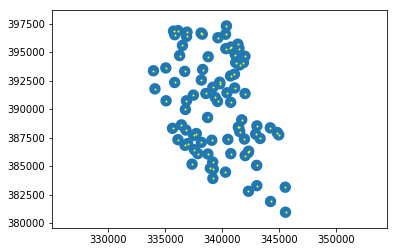

In [45]:
f, ax = plt.subplots(1)
# Plot buffer
buf.plot(ax=ax, linewidth=0)
# Plot named places on top for reference
# [NOTE how we modify the dot size (`markersize`)
# and the color (`color`)]
namp.plot(ax=ax, markersize=1, color='yellow')
plt.axis('equal')
plt.show()

---

**[Optional exercise]**

Generate a map of the Liverpool polygons in black and overlay on top of them yellow buffers of 250 metres around each centroid.

<!--
f, ax = plt.subplots(1)
b250 = namp.buffer(250)
# Plot polys
for poly in lsoas['geometry']:
    gpd.plotting.plot_multipolygon(ax, poly, edgecolor='black', facecolor='black')
# Plot buffer
for poly in buf:
    gpd.plotting.plot_multipolygon(ax, poly, linewidth=0, facecolor='yellow')
plt.axis('equal')
plt.show()
-->


---

**NOTE** The folowing are extensions and as such are not required to complete this section. They are intended as additional resources to explore further possibilities that Python allows to play with representing spatial data.

## `[Extension I]` Adding base layers from raster imagery

Sometimes, in addition to vector data, we need to rely on raster sources and combine both in the same map. For all things raster, Python has the library [`rasterio`](https://github.com/mapbox/rasterio), which provides simplified access to raster sources and many tools for manipulation, transformation, and integration.

In this example (based on this [other one](https://github.com/carsonfarmer/python_geospatial/blob/master/notebooks/Notebook3.ipynb) by Carson Farmer), we read in open data from the Ordnance Survey for the whole UK. The data corresponds with the GB Overview Map, and is obtained through an [OS Open Data](https://www.ordnancesurvey.co.uk/business-and-government/licensing/using-creating-data-with-os-products/os-opendata.html) license. The original source file can be downloaded from the following link:

> [https://www.ordnancesurvey.co.uk/opendatadownload/products.html](https://www.ordnancesurvey.co.uk/opendatadownload/products.html)

You can also download the file from the downloads section of the course website:

> [http://darribas.org/gds17/datasets.html](http://darribas.org/gds17/datasets.html)

To import the data using `rasterio`, we need to run the following code:

In [46]:
import rasterio
import numpy as np

# Reading in data
source = rasterio.open('figs/lab02_GBOverview.tif', 'r')
## Read red spectrum
red = source.read(1)
## Read green spectrum
green = source.read(2)
## Read blue spectrum
blue = source.read(3)
## Stack RGB values into a single array
pix = np.dstack((red, green, blue))
## Re-arrange bounding box to plot
bounds = (source.bounds.left, source.bounds.right, \
          source.bounds.bottom, source.bounds.top)

Once we have the data read, plotting it follows a similar pattern as we have seen before, except now we are using the `plt.imshow` command, which displays an image:

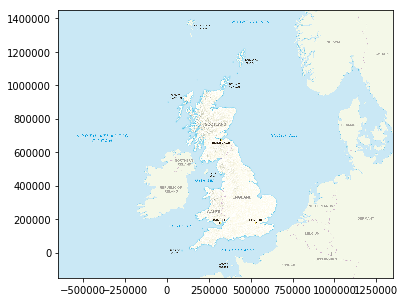

In [47]:
# Plotting
f = plt.figure(figsize=(6, 6))
ax = plt.imshow(pix, extent=bounds)

With a couple more of commands, we can zoom into the area of Liverpool and overlay the polygons as well. This requires adding the raster layer, then obtaining the coordinates for the limits of Liverpool, the zooming into those coordinates and, finally, adding the polygons:

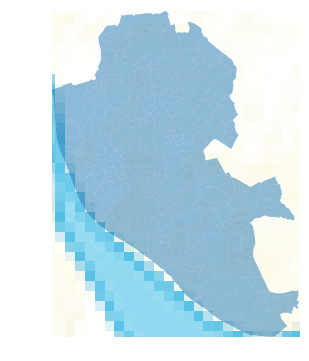

In [48]:
# Set up figure
f, ax = plt.subplots(figsize=(6, 6))
# Add raster
ax.imshow(pix, extent=bounds)
# Extract limits from Liverpool from LSOAs
w, s, e, n = lsoas.total_bounds
# Center figure on Liverpool limits
ax.set_xlim((w, e))
ax.set_ylim((s, n))
# Add polygon layer
lsoas.plot(ax=ax, alpha=0.5)
# Remove axis
plt.axis('off')
# Display figure
plt.show()

## `[Extension II]` Adding base layers from web sources

An alternative use of rasters is with web tiles, which are a straightforward way of quickly obtaining geographical context to present spatial data. In Python, we can use [`contextily`](https://github.com/darribas/contextily) to pull down tiles. Let us first import it:

In [49]:
import contextily as ctx

All we need is the coordinates in [Pseudo-Mercator](http://epsg.io/3857) coordinate system for the bounding box of choice:

In [50]:
lsoas_pm = lsoas.to_crs(epsg=3857)
w, s, e, n = lsoas_pm.total_bounds

The most straightforward way to add a basemap with `contextily` is calling the `add_basemap` method within a standard geographic plot:

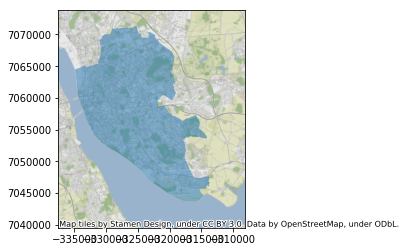

In [51]:
ax = lsoas_pm.plot(alpha=0.5)
ctx.add_basemap(ax)

To have further flexibility, we can unpack what `add_basemap` does under the hood. First,we  download the image (in this case, for zoom 13), with the following line:

In [52]:
img, ext = ctx.bounds2img(w, s, e, n, 13)

Then, the object `img` is an image, just as the `pix` object, which means we can easily plot it:

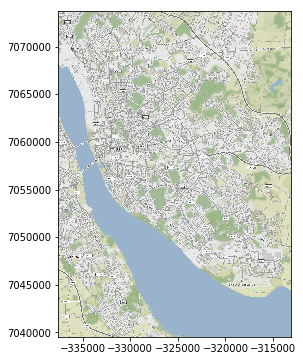

In [53]:
# Plotting
f = plt.figure(figsize=(6, 6))
ax = plt.imshow(img, extent=ext)

Explore the possibility of using different background maps with the `ctx.sources` submodule. Check [this](https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb) guide for more information.

## `[Extension III]` Advanced GIS operations

* Spatial joins

> [https://github.com/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb](https://github.com/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb)

* Spatial overlays

> [https://github.com/geopandas/geopandas/blob/master/examples/overlays.ipynb](https://github.com/geopandas/geopandas/blob/master/examples/overlays.ipynb)

---

<a rel="repo" href="https://github.com/darribas/gds18"><img alt="@darribas/gds18" style="border-width:0" src="../../GitHub-Mark.png" /></a>

This notebook, as well as the entire set of materials, code, and data included
in this course are available as an open Github repository available at: [`https://github.com/darribas/gds18`](https://github.com/darribas/gds18)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'18</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

